# Short Demo For Tangles Clustering

In [1]:
import numpy as np

from sklearn.datasets import make_blobs
from sklearn.metrics import normalized_mutual_info_score as NMI
from functools import partial
import cut_finding

import dataset_generation

import seaborn as sns
import tangles
import cost_functions
import cut_finding
from collections import Counter
import plotting
import dataset_generation
import matplotlib.pyplot as plt


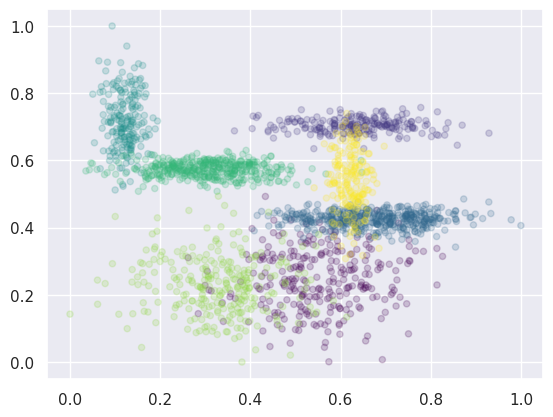

In [24]:
# Generate Data
np.random.seed(1000)
n_clusters = 7
dimensions = 2
data_size = 2000
min_distance = 3

def means_func(size):
    return 12 * np.random.random(size=size)

data, labels = dataset_generation.create_2d_test_data(
                means_func=means_func,
                n_clusters=n_clusters,
                dimensions=dimensions,
                scales=np.random.choice([0.5, 2], size=(n_clusters, dimensions)),
                weights=0.25 + 0.75*np.random.random(size=n_clusters),
                min_distance= min_distance,
                num_samples=data_size
            )

sns.set_theme(style='darkgrid')

plt.scatter(data[:, 0], data[:, 1], c=labels, s=20, alpha=0.2, cmap='viridis')
plt.show()

In [25]:

# Set agreement param to 40% of the smallest cluster size
# This is cheating, as we are using the true labels to compute this
agreement_param = min(Counter(labels).values()) * 0.4

# Generate Cuts - Agreement param here must be smaller than the agreement
# passed to the algorithm. This generates 50 cuts along each axis
cuts = cut_finding.range_axis_parallel(data, agreement_param=data_size / 50)

# Compute their costs
cuts, costs = cost_functions.BorderDistances(data).compute(cuts)

# Initialize Tangles Clustering
tangles_clustering = tangles.TangleClustering(
    cuts=cuts, costs=costs, agreement_param=agreement_param)

# Optionally we can also just pass the cut and cost functions directly
tangles_clustering = tangles.TangleClustering(
    cut_function=partial(cut_finding.range_axis_parallel,
                         agreement_param=data_size / 50),
    agreement_param=agreement_param,
    cost_class=cost_functions.BorderDistances)

# Compute the tangle tree, contract it, and compute distinguished cuts.
tangles_clustering.fit(data)

# We can at this stage print the tangle tree
# The nodes represent the orientation used for splitting in the
print(tangles_clustering.root)


              ____5__________
             /               \
      _____-10            ____-7___________
     /        \          /                 \
   _21_        83     _-15            _____-15
  /    \             /    \          /        \
-29    -28          23     39      _21_        65
                                  /    \
                                 52    -59



/home/oscar/git/TanglesClustering/tangles.py:540: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(cluster[:, 0], cluster[:, 1], color=colors[i],


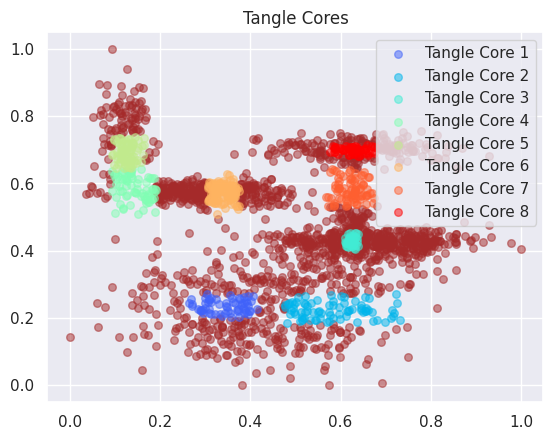

In [26]:
# We can also plot cores of the leaf tangles
tangles_clustering.plot_tangles(data)

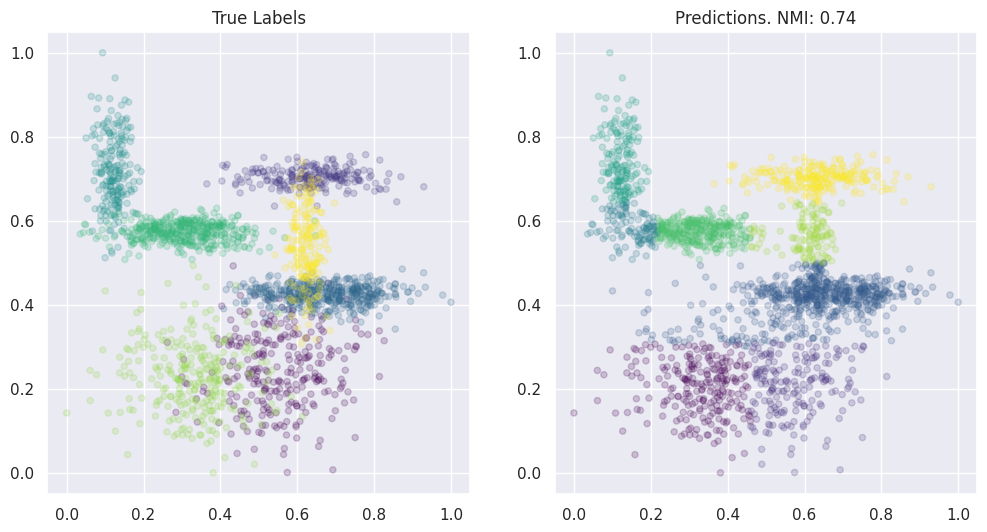

In [27]:
# Compute hard-predictions for the data.
# the model has the attribute soft_predictions, if needed
hard_predictions = tangles_clustering.predict()

# We can plot the predictions

def plot_predictions(data, labels, hard_predictions):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(data[:, 0], data[:, 1], c=labels, s=20, alpha=0.2, cmap='viridis')
    plt.title('True Labels')
    plt.subplot(1, 2, 2)
    plt.scatter(data[:, 0], data[:, 1], c=hard_predictions, s=20, alpha=0.2, cmap='viridis')
    plt.title('Predictions. NMI: {:.2f}'.format(NMI(labels, hard_predictions)))
    plt.show()

plot_predictions(data, labels, hard_predictions)